# Laptop Price Prediction Using Machine Learning

This project aims to predict laptop prices based on features such as brand, screen resolution, RAM, processor type, and storage. The model will provide insights into pricing trends and help consumers make informed decisions.


## Problem Statement

Predicting laptop prices is challenging due to various features influencing the cost, such as screen resolution, performance, and brand. This project builds a machine learning model to accurately predict laptop prices using a real-world dataset.


### 1. Importing Required Libraries
Importing the necessary libraries for data manipulation, visualization, and machine learning.


In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.metrics import r2_score

import joblib


### 2. Configurations
Set display options for better visualization in Jupyter Notebook.

In [251]:
#pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
sklearn.set_config(transform_output="pandas")

### 3. Loading the Dataset
Load the dataset into a Pandas DataFrame for preprocessing and analysis.

In [252]:
df_original=pd.read_csv("few_laptop_data.csv")

In [253]:
df=df_original.copy()
df.sample(1)

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
525,525,Lenovo,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,2.02kg,71395.2


### Display dataset information

In [254]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price             1303 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 122.3+ KB


### Dataset Overview
- **Total Rows**: 1303
- **Total Columns**: 12
- **Memory Usage**: 122.3 KB
- **Column Types**:
  - Numerical: 2 (e.g., `Inches`, `Price`)
  - Categorical: 9 (e.g., `Company`, `TypeName`)
  - Mixed: 1 (e.g., `Memory`)

#### Key Observations:
1. All columns have non-null values, meaning no missing data.
2. `Price` is the target variable and has a **continuous float64 type**.



### Drop unnecessary columns

In [255]:
df.drop(columns=['Unnamed: 0'],inplace=True)

### Removing duplicates rows

In [256]:
print(f"Rows before: {len(df)}")
df = df[~df.duplicated(keep='first')]
print(f"Rows after: {len(df)}")

Rows before: 1303
Rows after: 1274


### Duplicate Removal
- **Initial Row Count**: 1303
- **Row Count After Removal**: 1274
- **Duplicates Removed**: 29
- **Reason**: To ensure unique rows for accurate analysis and modeling.


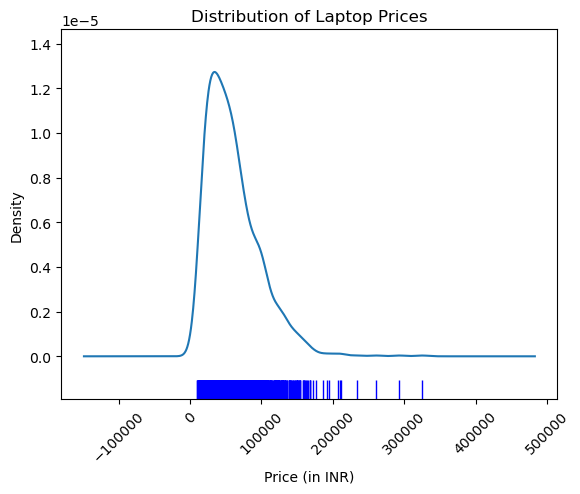

In [257]:
df["Price"].plot(kind='kde')
sns.rugplot(df['Price'],height=0.05,color="Blue")
plt.title('Distribution of Laptop Prices')
plt.xlabel('Price (in INR)')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.show()


### Observations:
1. **Right-Skewed Distribution:**

     - The majority of the laptops are priced on the lower end, with a sharp peak in the density plot.
     - There is a long tail extending toward higher price values, indicating a few premium laptops with much higher prices.

2. **Presence of Outliers:**

     - The rug plot shows a concentration of prices on the lower end, with sparse data points at higher prices.
     - Outliers might exist in the higher price range, which can influence the analysis and modeling.

3. **Density Peaks:**

     - The plot shows a primary density peak around the lower price range, suggesting the majority of laptops are priced affordably.
     - To address the skewness, apply a log transformation to the Price column. This will compress the range of higher values and make the distribution more normal-like:

In [258]:
df['Price']=df.Price.astype('int64')

In [259]:
y=np.log1p(df["Price"])

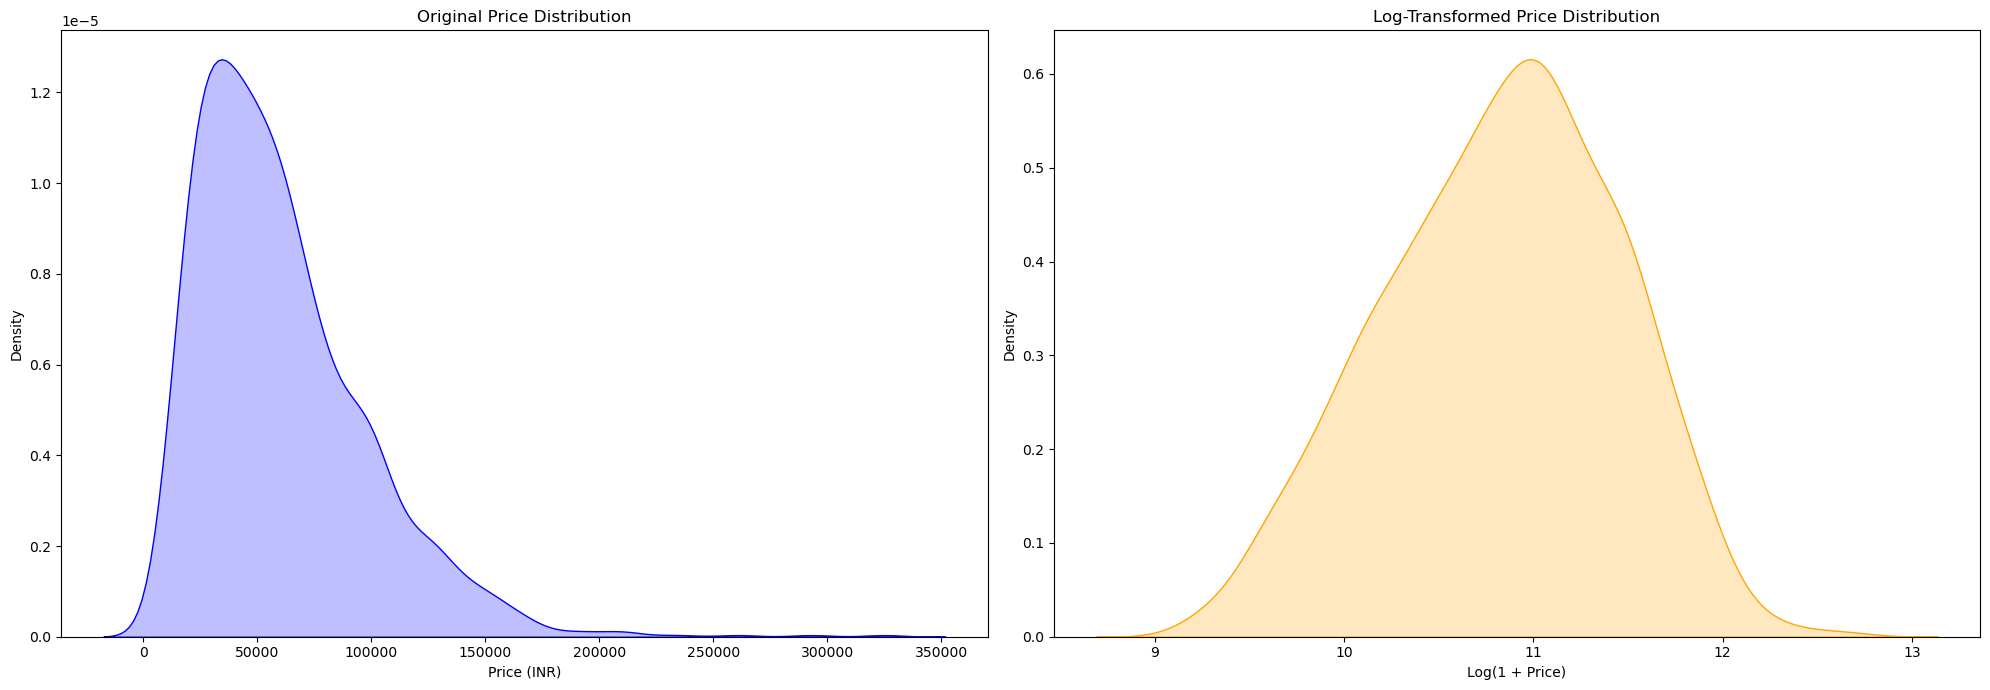

In [260]:
y = np.log1p(df["Price"])

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20,7))

# KDE for Original Price
sns.kdeplot(df['Price'], ax=axes[0], color="blue", fill=True)
axes[0].set_title("Original Price Distribution")
axes[0].set_xlabel("Price (INR)")
axes[0].set_ylabel("Density")

# KDE for Log-Transformed Price
sns.kdeplot(y, ax=axes[1], color="orange", fill=True)
axes[1].set_title("Log-Transformed Price Distribution")
axes[1].set_xlabel("Log(1 + Price)")
axes[1].set_ylabel("Density")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


**Right Plot (Log-Transformed Price Distribution):**

    - After applying log1p (logarithm transformation), the distribution becomes more symmetric and normal-like.
    - The peak is more centered, which helps reduce the effect of outliers during model training.
    - This transformation will improve the model's ability to learn patterns and generalize better.

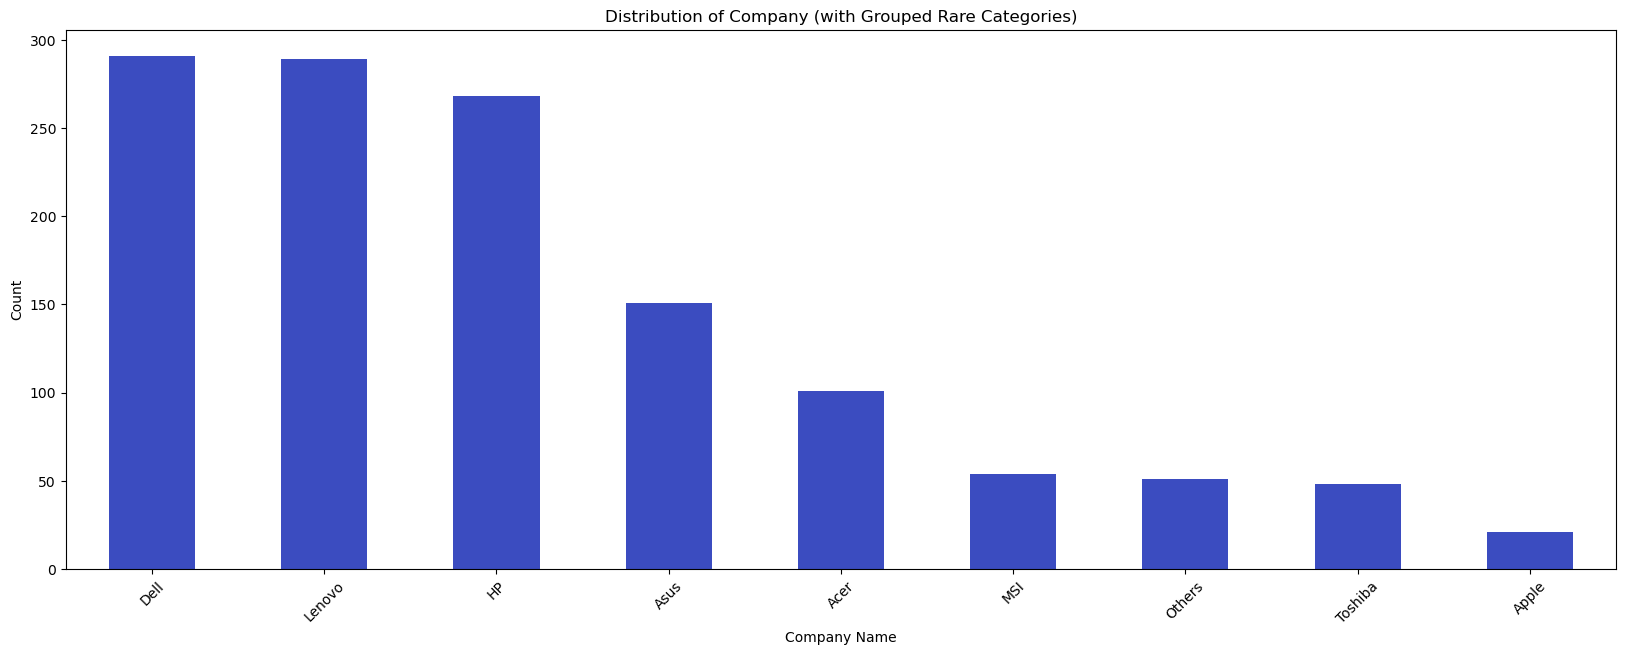

In [261]:
# Set a threshold to group rare categories
threshold = 10  # Minimum count to consider a category "frequent"

# Group less frequent categories into 'Others'
company_counts = df['Company'].value_counts()
df['Company'] = df['Company'].apply(lambda x: x if company_counts[x] >= threshold else 'Others')

# Plot the grouped data
plt.figure(figsize=(20, 7))
df['Company'].value_counts().plot(kind='bar', cmap='coolwarm')
plt.title('Distribution of Company (with Grouped Rare Categories)')
plt.xlabel('Company Name')
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


### Note on Brand Distribution for Prediction Modeling:

The distribution of brands in the dataset shows that a few brands like **Dell**, **Lenovo**, and **HP** dominate the market, while others like **Apple**, **MSI**, and **Toshiba** have smaller representation. Rare categories have been grouped under "Others" to simplify analysis and avoid overfitting. 

This grouping ensures the model focuses on meaningful patterns without being biased by underrepresented brands, making the feature more reliable for prediction.


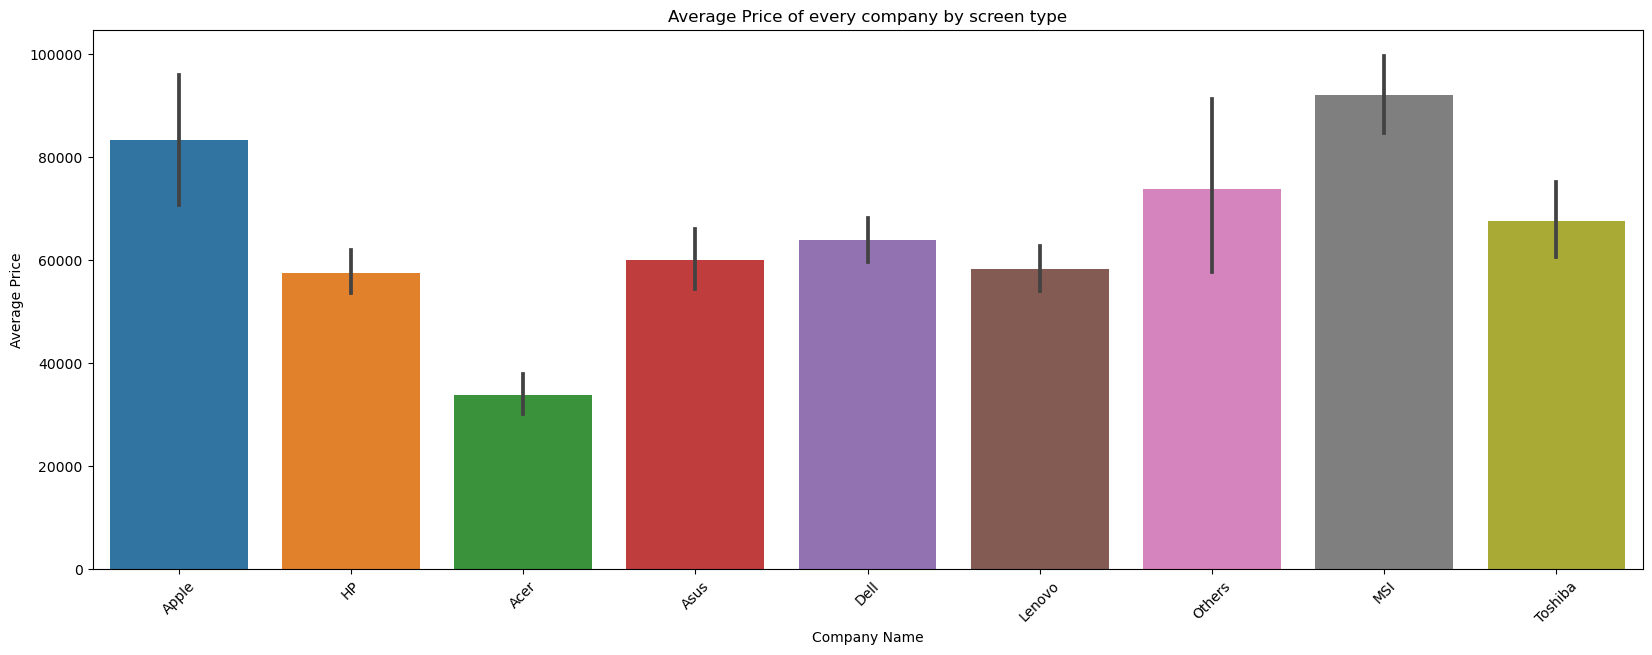

In [262]:
# Set a threshold to group rare categories
threshold = 10  # Minimum count to consider a category "frequent"

# Group less frequent categories into 'Others

plt.figure(figsize=(20,7))
sns.barplot(x=df['Company'],y=df['Price'])
plt.title('Average Price of every company by screen type')
plt.xlabel('Company Name')
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

### Visualization: Average Price of Laptops by Brand

#### Insights:
1. **Apple** stands out with the highest average price, along with a significant variation in prices, as indicated by the error bars. This reflects both premium pricing and a range of product tiers.
2. **HP, Dell, and Asus** maintain moderate price levels with relatively smaller error bars, showing a more consistent pricing structure across their offerings.
3. **Acer** exhibits the lowest average price, with a narrow error bar indicating a focus on budget-friendly models with less price variability.
4. **MSI** has a high average price and a noticeable variation, likely reflecting its focus on gaming laptops, which vary widely in specifications and prices.
5. **Grouped 'Others' category** captures a mix of brands with diverse price points, leading to broader error bars.
6. **Toshiba** has a moderate average price with less variation, indicating a targeted market segment.

#### Conclusion:
This analysis highlights the significance of the **Brand** feature as a strong predictor for laptop pricing due to its influence on pricing tiers and product variability.


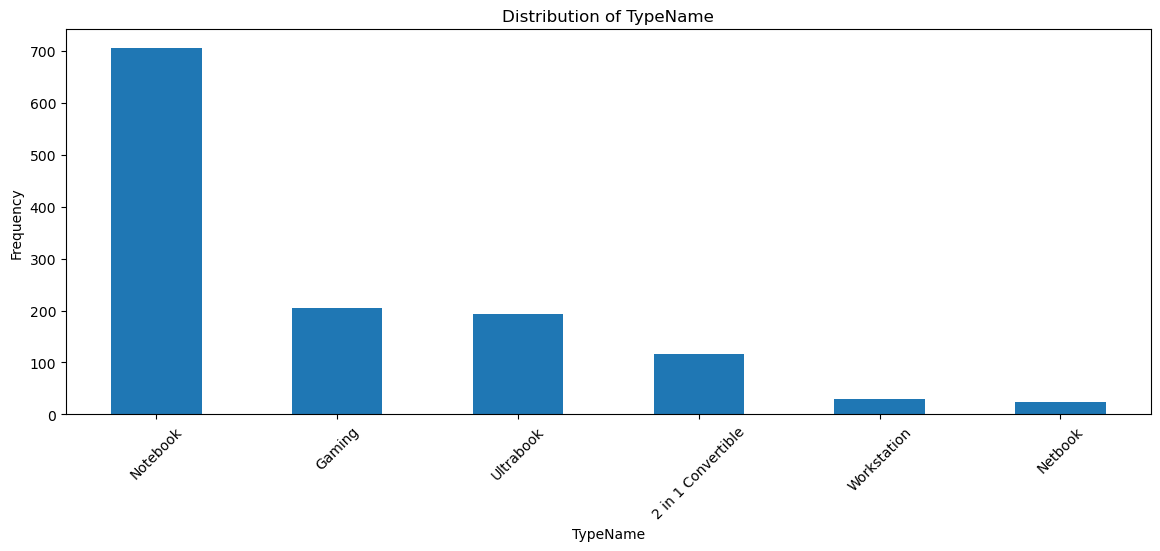

In [263]:
plt.figure(figsize=(14,5))
df['TypeName'].value_counts().plot(kind='bar')
plt.title('Distribution of TypeName')
plt.xlabel('TypeName')
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


### Distribution of (TypeName)

The bar chart shows the distribution of laptops by their type:

- **Dominant Category**: Notebooks are the most common, representing the majority of the dataset, reflecting their popularity for general use.
- **Specialized Categories**: Gaming and Ultrabooks follow, catering to specific needs like performance.
- **Niche Categories**: 2-in-1 Convertibles, Workstations, and Netbooks are less frequent, targeting unique market segments.

#### Key Insight:
This distribution indicates a diverse dataset, where the TypeName feature captures essential variations in laptop functionality and target audience.


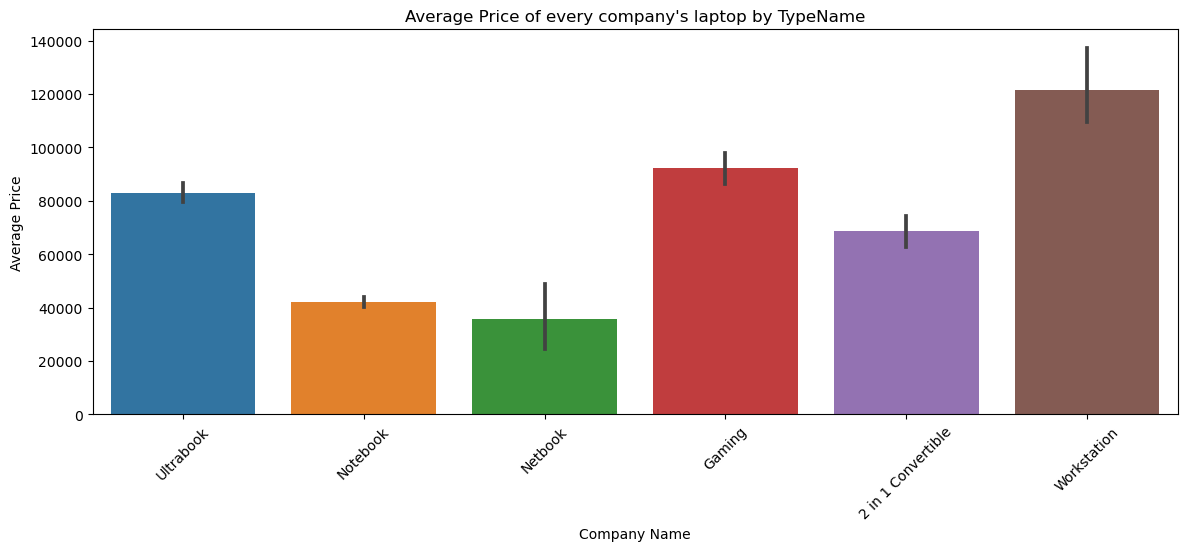

In [264]:
plt.figure(figsize=(14,5))
sns.barplot(x=df['TypeName'],y=df['Price'])
plt.title("Average Price of every company's laptop by TypeName")
plt.xlabel('Company Name')
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

### Key Insight: Average Price of Laptops by TypeName

- **Ultrabooks** have a higher average price compared to other mid-range categories.
- **2-in-1 Convertibles** show a moderate average price, lower than Ultrabooks and Gaming laptops.
- **Gaming laptops** and **Workstations** display the highest average prices among all categories.
- **Notebooks** and **Netbooks** are on the lower end of the price spectrum.

### Conclusion:
The "TypeName" feature clearly differentiates laptop pricing and is valuable for prediction modeling.


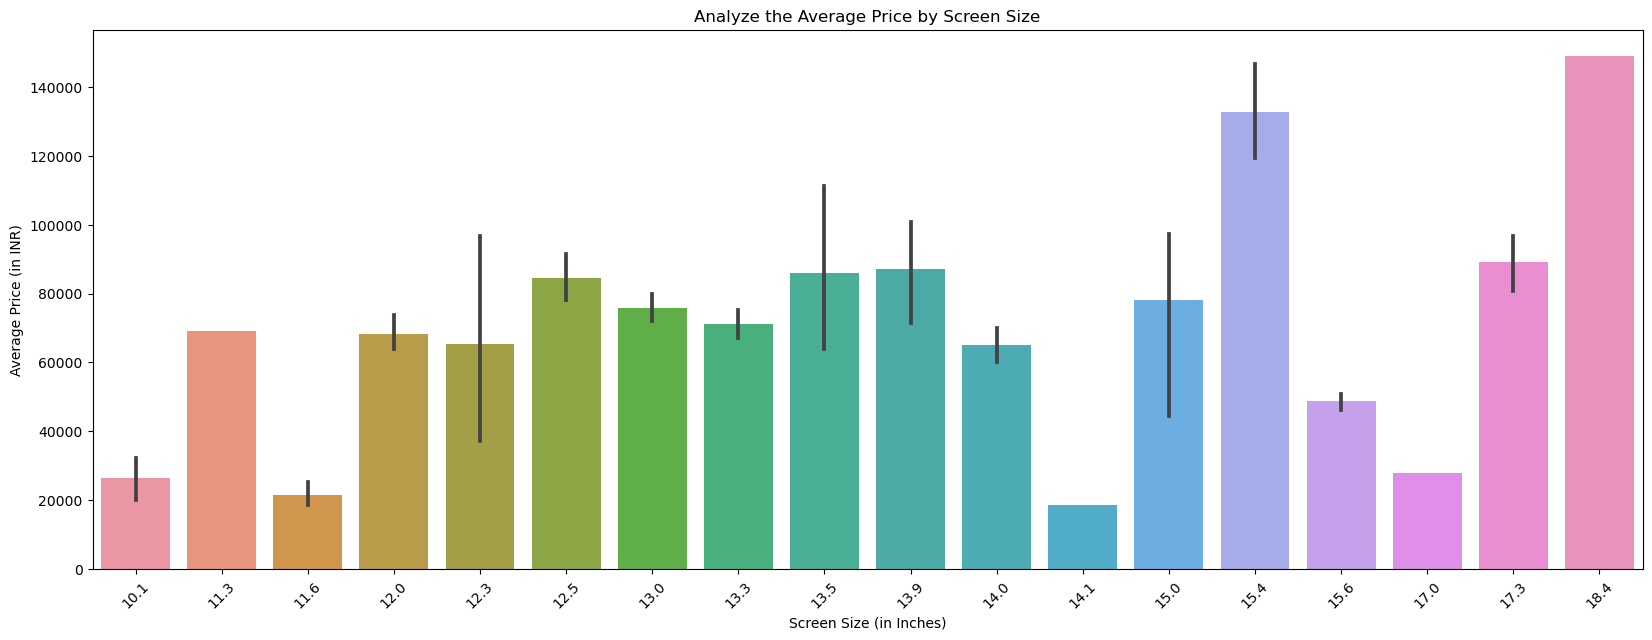

In [265]:
plt.figure(figsize=(20,7))
sns.barplot(x=df['Inches'], y=df['Price'])  # Use errorbar=None to disable error bars
plt.title("Analyze the Average Price by Screen Size")
plt.xlabel("Screen Size (in Inches)")
plt.ylabel("Average Price (in INR)")
plt.xticks(rotation=45)
plt.show()

### Key Insights on Screen Size (Inches) for Prediction Modeling

1. **12 to 14 Inches**: Laptops within this range tend to have moderate pricing, indicating a balance between portability and performance.
2. **14.1 Inches**: This size shows the lowest average price, suggesting it may cater to budget-oriented options.
3. **18.4 Inches**: Laptops with this screen size have the highest average price, followed by 15.4-inch laptops, likely due to enhanced features or premium build quality.

#### Relevance for Prediction:
The screen size significantly influences laptop pricing, making it a valuable feature for the predictive model. The distinct trends across different sizes can help the model differentiate between various pricing tiers effectively.


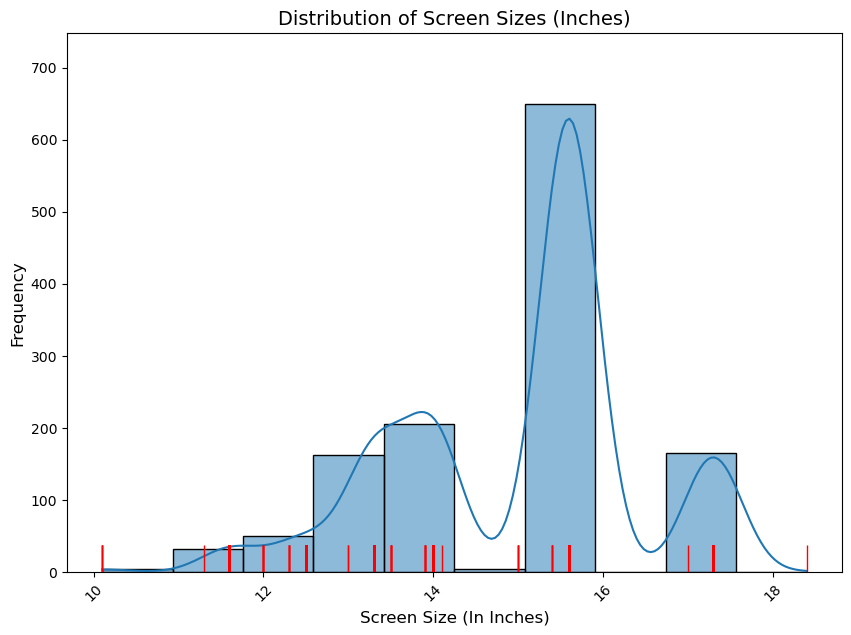

In [266]:
plt.figure(figsize=(10,7))
# Create the histogram with KDE
sns.histplot(df['Inches'], kde=True, bins=10)

# Add a rugplot
sns.rugplot(df['Inches'], height=0.05, color='red')  # Customize rug height and color

# Customize the plot
plt.title('Distribution of Screen Sizes (Inches)', fontsize=14)
plt.xlabel('Screen Size (In Inches)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

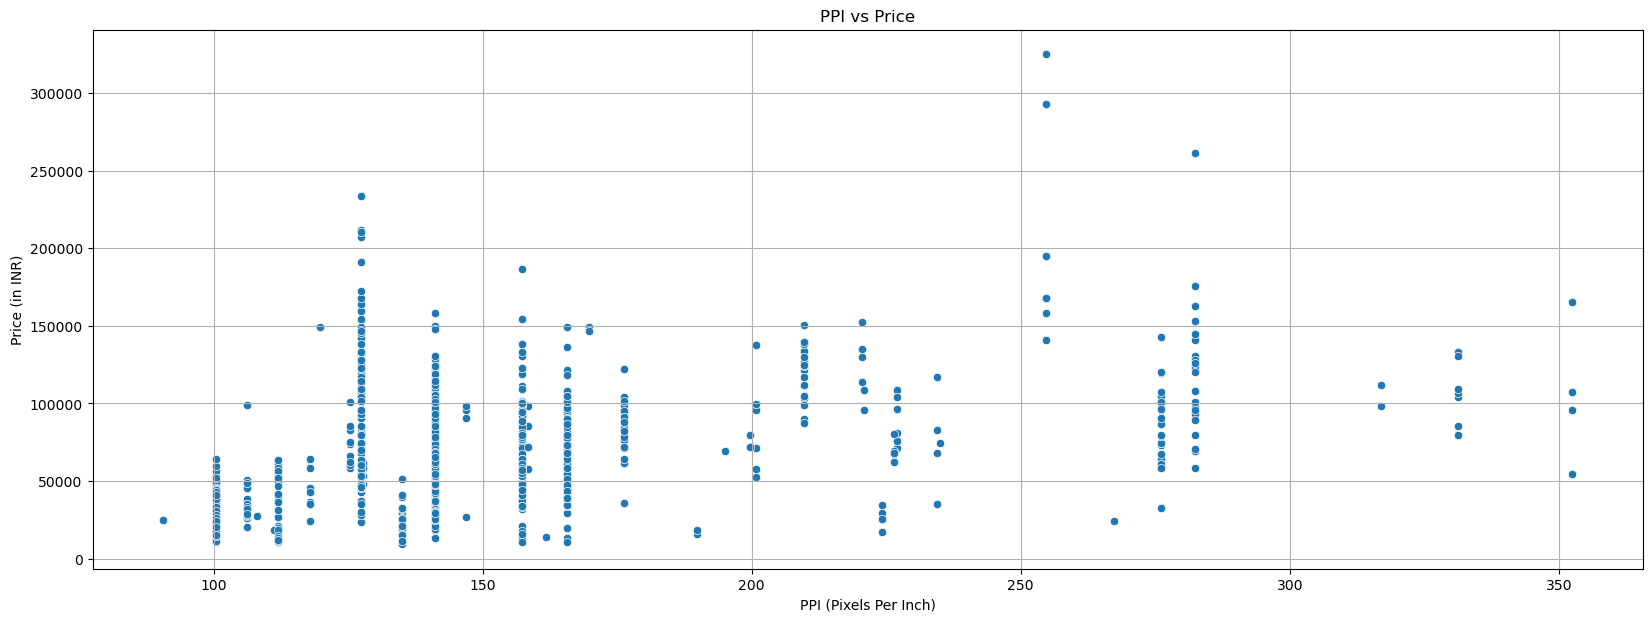

In [267]:
plt.figure(figsize=(20,7))
# Calculate PPI (Pixels Per Inch) - A Key Feature for Screen Quality
df['ScreenResolution_Width']=df['ScreenResolution'].str.split(" ").str.get(-1).str.extract(r'(\d+)x').astype(int)
df['ScreenResolution_Height'] = df['ScreenResolution'].str.split(" ").str.get(-1).str.extract(r'x(\d+)').astype(int)

# Derive PPI using the screen width, height, and screen size (inches)
df['PPI'] = np.sqrt(df['ScreenResolution_Width']**2 + df['ScreenResolution_Height']**2) / df['Inches']

# Visualize the relationship between PPI and Price
sns.scatterplot(x=df['PPI'], y=df['Price'])
plt.title('PPI vs Price')
plt.xlabel('PPI (Pixels Per Inch)')
plt.ylabel('Price (in INR)')
plt.grid(True)
plt.show()


### Insight: Pixel Density (PPI) vs Price

- The scatter plot shows a **positive correlation** between Pixel Density (PPI) and laptop prices.
- Higher PPI values generally align with higher prices, as laptops with better display quality tend to cost more.
- However, the correlation is **not very strong**, as there are overlaps in price ranges for different PPI values.
- This indicates that while PPI is an important feature for predicting prices, it should be used alongside other features for a more accurate prediction.


[]

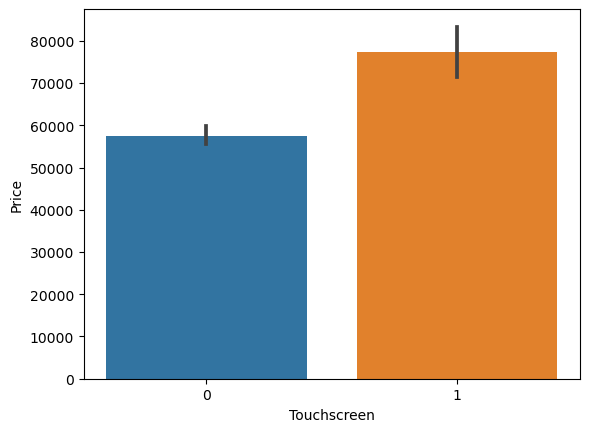

In [268]:
df['Touchscreen']=df['ScreenResolution'].apply(lambda x : 1 if 'Touchscreen' in x else 0)
sns.barplot(x=df['Touchscreen'],y=df['Price'])
plt.plot()

### Insight: Touchscreen vs Price

- The bar plot clearly shows that laptops with a touchscreen (1) have a **higher average price** compared to those without a touchscreen (0).
- This indicates that the presence of a touchscreen significantly impacts the price of a laptop.
- Including the "Touchscreen" feature in the predictive model is important as it adds value to understanding price variations.


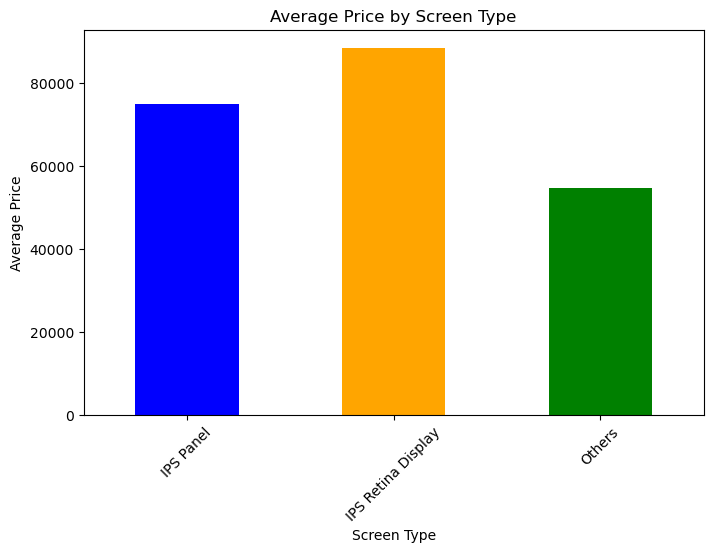

In [269]:
def get_panel_type(screen):
    if 'IPS Panel' in screen and 'Retina Display' in screen:
        return 'IPS Retina Display'
    elif 'Retina Display' in screen:
        return 'Retina Display'
    elif 'IPS Panel' in screen:
        return 'IPS Panel'
    else:
        return 'Others'

df['Panel_Type']=df['ScreenResolution'].apply(get_panel_type)

# Group by Screen_Type and calculate average price
price_by_screen_type = df.groupby('Panel_Type')['Price'].mean()

# Visualize the result
price_by_screen_type.plot(kind='bar', color=['blue', 'orange', 'green', 'red'], figsize=(8, 5))
plt.title('Average Price by Screen Type')
plt.xlabel('Screen Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


### Insight: Average Price by Screen Type

- **IPS Retina Display** screens have the highest average price among the screen types.
- **IPS Panel** screens are moderately priced but higher than the "Others" category.
- The "Others" screen type category has the lowest average price.

### Relevance for Prediction Modeling:
- The screen type significantly impacts laptop pricing and should be included as a feature in the predictive model. The price difference across screen types highlights its predictive importance.


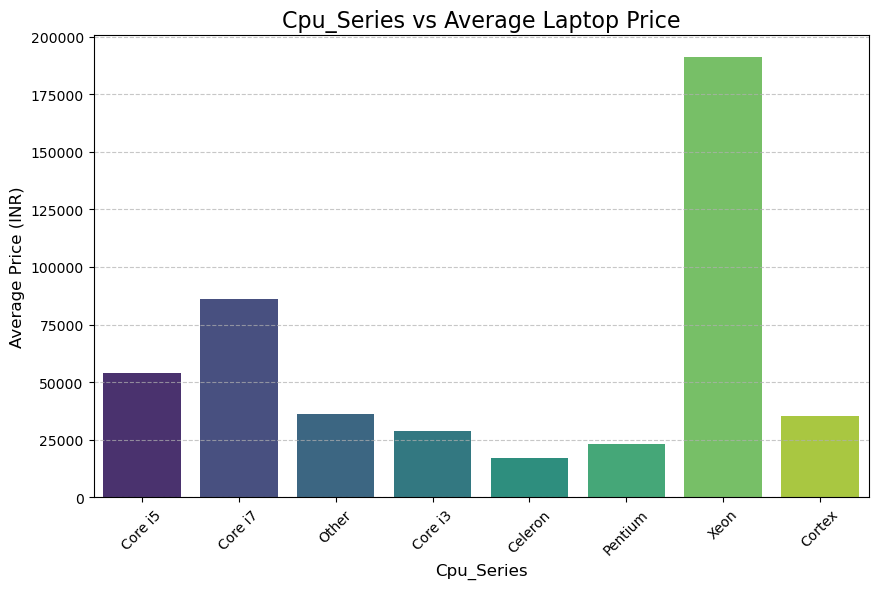

In [270]:
# Define a function to classify CPU series
def get_cpu_series(cpu):
    if 'Core i3' in cpu or 'i3' in cpu:
        return 'Core i3'
    elif 'Core i5' in cpu or 'i5' in cpu:
        return 'Core i5'
    elif 'Core i7' in cpu or 'i7' in cpu:
        return 'Core i7'
    elif 'Core i9' in cpu or 'i9' in cpu:
        return 'Core i9'
    elif 'Ryzen 3' in cpu:
        return 'Ryzen 3'
    elif 'Ryzen 5' in cpu:
        return 'Ryzen 5'
    elif 'Ryzen 7' in cpu:
        return 'Ryzen 7'
    elif 'Pentium' in cpu:
        return 'Pentium'
    elif 'Celeron' in cpu:
        return 'Celeron'
    elif 'Xeon' in cpu:
        return 'Xeon'
    elif 'Athlon' in cpu:
        return 'Athlon'
    elif 'Cortex' in cpu:
        return 'Cortex'
    else:
        return 'Other'

# Apply the function to the Cpu column
df['Cpu_Series'] = df['Cpu'].apply(get_cpu_series)
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Cpu_Series'], y=df['Price'], errorbar=None, palette="viridis")
plt.title('Cpu_Series vs Average Laptop Price', fontsize=16)
plt.xlabel('Cpu_Series', fontsize=12)
plt.ylabel('Average Price (INR)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Insight: CPU Series vs Average Laptop Price

- **Xeon processors** have the highest average price among all CPU series, significantly higher than other series.
- **Core i7** processors are priced higher on average compared to **Core i5**, showing a clear distinction in pricing within the Core series.
- Other CPU series like **Celeron** and **Pentium** have the lowest average prices, indicating budget-oriented usage.
- **Core i3** lies in a similar price range to Celeron and Pentium, while **Core i5** and **Core i7** show a notable price increase.

### Relevance for Prediction Modeling:
- CPU series is a critical feature for price prediction as it directly influences the pricing structure. The distinct pricing patterns observed across different CPU series highlight its predictive importance.


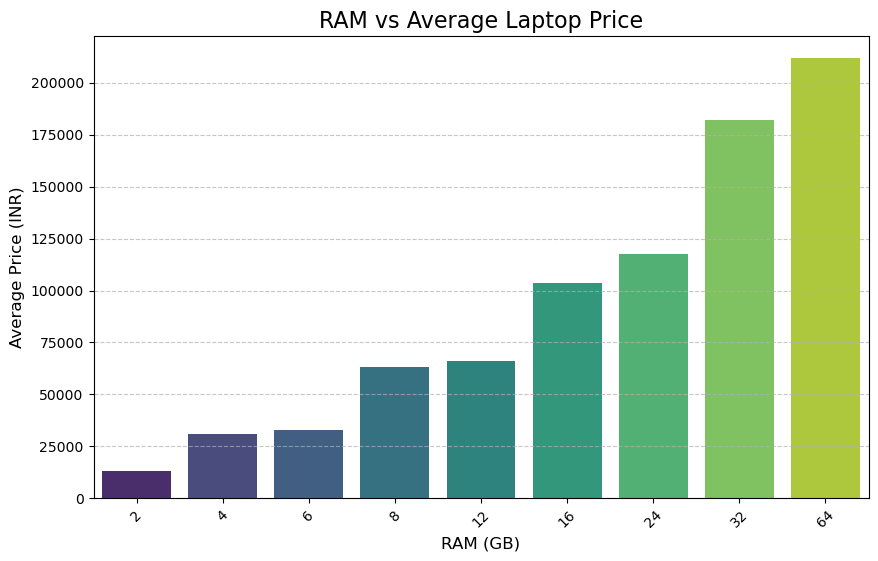

In [271]:
# Convert RAM column to integer after removing the 'GB' unit
df['Ram'] = df['Ram'].str.replace('GB', '').astype('int64')

# Create a bar plot to analyze the relationship between RAM and Price
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Ram'], y=df['Price'], errorbar=None, palette="viridis")
plt.title('RAM vs Average Laptop Price', fontsize=16)
plt.xlabel('RAM (GB)', fontsize=12)
plt.ylabel('Average Price (INR)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Insight: RAM vs Average Laptop Price

- Laptops with **higher RAM** capacity show a clear upward trend in pricing.
- **64 GB RAM** laptops have the highest average price, followed by **32 GB** and **24 GB** configurations.
- Laptops with **2 GB to 8 GB RAM** are in the lower price range, indicating budget-friendly options.
- The price difference between consecutive RAM configurations becomes more noticeable with higher capacities (e.g., 16 GB vs 24 GB).

### Relevance for Prediction Modeling:
- RAM size is a significant feature for predicting laptop prices due to its strong positive correlation with pricing. This pattern highlights its importance in capturing the price variance across different configurations.


In [272]:
# Step 1: Function to extract storage capacity for specific types
def extract_storage(memory_string, storage_type):
    """
    Extracts total storage for a given storage type (e.g., SSD, HDD).
    """
    if pd.isna(memory_string):  # Handle NaN values
        return 0

    total = 0
    for part in memory_string.split('+'):  # Split by '+' to handle combinations
        part = part.strip()  # Remove leading/trailing spaces
        if storage_type in part:  # Check if the specific storage type is in the part
            if 'TB' in part:  # If TB is found, convert it to GB
                total += float(part.split('TB')[0]) * 1024
            elif 'GB' in part:  # If GB is found, add directly
                total += float(part.split('GB')[0])
    return int(total)

# Step 2: Apply the function to extract SSD and HDD capacities
df['SSD_Capacity_GB'] = df['Memory'].apply(lambda x: extract_storage(x, 'SSD'))
df['HDD_Capacity_GB'] = df['Memory'].apply(lambda x: extract_storage(x, 'HDD'))

# Step 3: Extract binary flags for each storage type
df['Has_SSD'] = df['SSD_Capacity_GB'].apply(lambda x: 1 if x > 0 else 0)
df['Has_HDD'] = df['HDD_Capacity_GB'].apply(lambda x: 1 if x > 0 else 0)
df['Has_FlashStorage'] = df['Memory'].apply(lambda x: 1 if 'Flash Storage' in str(x) else 0)


In [273]:
df.sample(3)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,ScreenResolution_Width,ScreenResolution_Height,PPI,Touchscreen,Panel_Type,Cpu_Series,SSD_Capacity_GB,HDD_Capacity_GB,Has_SSD,Has_HDD,Has_FlashStorage
750,Lenovo,Netbook,11.6,Touchscreen 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,128GB SSD,Intel HD Graphics 400,Windows 10,1.4kg,25308,1366,768,135.094211,1,Others,Celeron,128,0,1,0,0
355,Dell,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8,128GB SSD + 2TB HDD,AMD Radeon 530,Windows 10,2.02kg,51729,1920,1080,141.211998,0,Others,Core i7,128,2048,1,1,0
1113,HP,Ultrabook,13.3,Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,8,512GB SSD,Intel HD Graphics 520,Windows 10,1.16kg,104908,1920,1080,165.632118,0,Others,Core i7,512,0,1,0,0


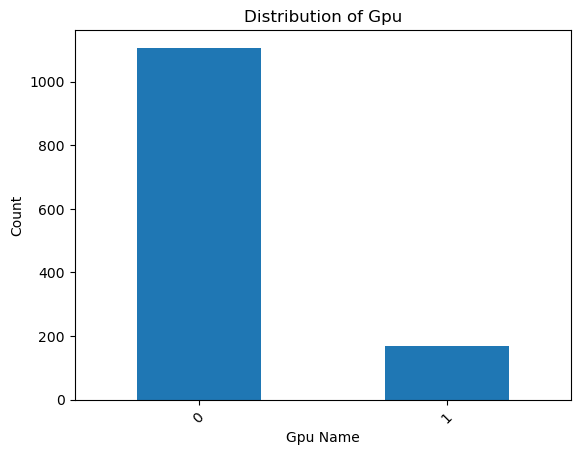

In [274]:
def is_dedicated(gpu):
    """
    Determines whether the GPU is dedicated or integrated.
    Returns 1 for dedicated GPUs (e.g., NVIDIA, AMD Radeon), 0 for integrated GPUs (e.g., Intel HD Graphics).
    """
    if 'NVIDIA' in gpu or 'AMD Radeon' in gpu:
        return 1  # Dedicated GPU
    else:
        return 0  # Integrated GPU

# Apply the function to the 'Gpu' column
df['Dedicated_GPU'] = df['Gpu'].apply(is_dedicated)
df['Dedicated_GPU'].value_counts().plot(kind='bar')
plt.title('Distribution of Gpu')
plt.xlabel('Gpu Name')
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

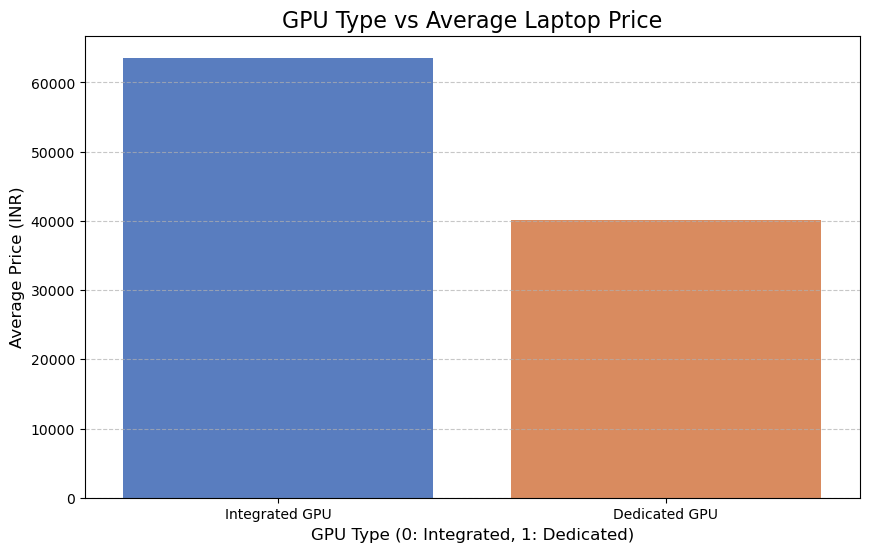

In [275]:
# Plot GPU type (Dedicated vs Integrated) against Average Price
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Dedicated_GPU'], y=df['Price'], errorbar=None, palette="muted")
plt.title('GPU Type vs Average Laptop Price', fontsize=16)
plt.xlabel('GPU Type (0: Integrated, 1: Dedicated)', fontsize=12)
plt.ylabel('Average Price (INR)', fontsize=12)
plt.xticks([0, 1], ['Integrated GPU', 'Dedicated GPU'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Insights on GPU Type and Pricing:

1. **Distribution of GPUs**:
   - The majority of laptops in the dataset have **integrated GPUs**, while a smaller proportion has **dedicated GPUs**.

2. **GPU Type vs. Average Price**:
   - Surprisingly, laptops with **integrated GPUs** show a **higher average price** compared to those with **dedicated GPUs** in this dataset.
   - This result is unexpected, as dedicated GPUs are generally associated with higher costs due to their better performance for gaming or graphics-intensive tasks.

3. **Possible Factors**:
   - The higher price of integrated GPU laptops may be influenced by other premium features such as:
     - **Brand** (e.g., high-end brands might use integrated GPUs in ultrabooks).
     - **Screen Resolution** or **PPI**.
     - **CPU type** or other specifications.
   - Further analysis is needed to confirm if features like **RAM**, **brand**, or **screen type** contribute to this pattern.

4. **Next Steps**:
   - Investigate additional features to better understand this anomaly.
   - Ensure the dataset is balanced and free from mislabeling or errors.

**Conclusion**:
- GPU type appears to influence pricing, but the current pattern suggests the need for deeper analysis to explain why integrated GPUs are associated with higher average prices.


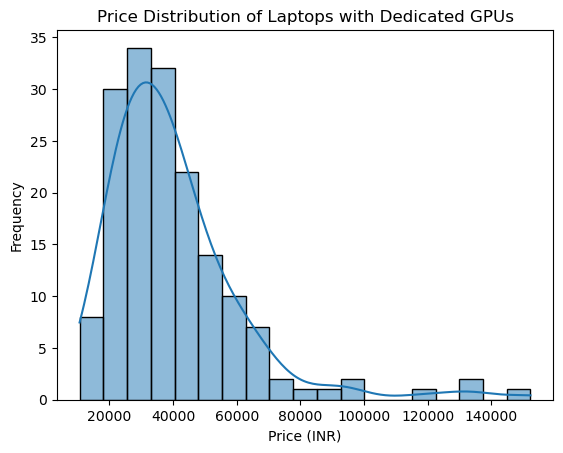

In [276]:
# Filter laptops with dedicated GPUs and plot the price distribution
sns.histplot(df[df['Dedicated_GPU'] == 1]['Price'], kde=True)
plt.title("Price Distribution of Laptops with Dedicated GPUs")
plt.xlabel("Price (INR)")
plt.ylabel("Frequency")
plt.show()

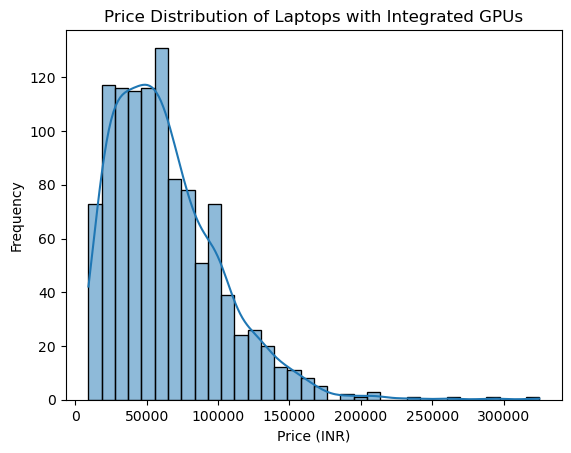

In [277]:
# Filter laptops with Integrated GPUs and plot the price distribution
sns.histplot(df[df['Dedicated_GPU'] == 0]['Price'], kde=True)
plt.title("Price Distribution of Laptops with Integrated GPUs")
plt.xlabel("Price (INR)")
plt.ylabel("Frequency")
plt.show()

From both figures, it is evident that dedicated GPU laptops dominate the mid-range pricing (₹20,000–₹60,000), while integrated GPU laptops have a higher average price, clustering around ₹50,000 due to their use in premium and productivity-focused laptops. This pricing pattern is a key factor in explaining why the overall average price of laptops with dedicated GPUs is lower than those with integrated GPUs.


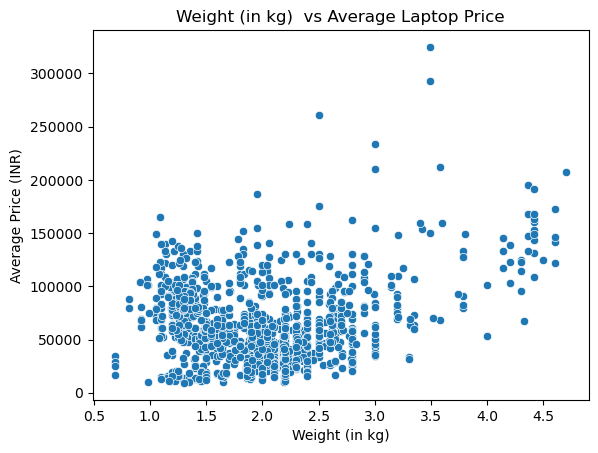

In [278]:
df['Weight'] = df['Weight'].str.replace("kg","").astype(float)
sns.scatterplot(x=df['Weight'], y=df['Price'])
plt.title('Weight (in kg)  vs Average Laptop Price')
plt.xlabel('Weight (in kg)')
plt.ylabel('Average Price (INR)')
plt.show()

The scatter plot shows the relationship between laptop weight and price. Most laptops cluster around weights between 1.0 kg to 3.0 kg, with prices ranging widely within this range. While there is some variation in price across different weights, the distribution appears fairly spread out, indicating no strong correlation between weight and price. 

**Insight:** Heavier laptops tend to be priced higher, likely due to additional hardware like dedicated GPUs or larger batteries. However, this trend is not consistent enough to make weight a standalone strong predictor for laptop pricing. It can still add value when combined with other features in the predictive model.


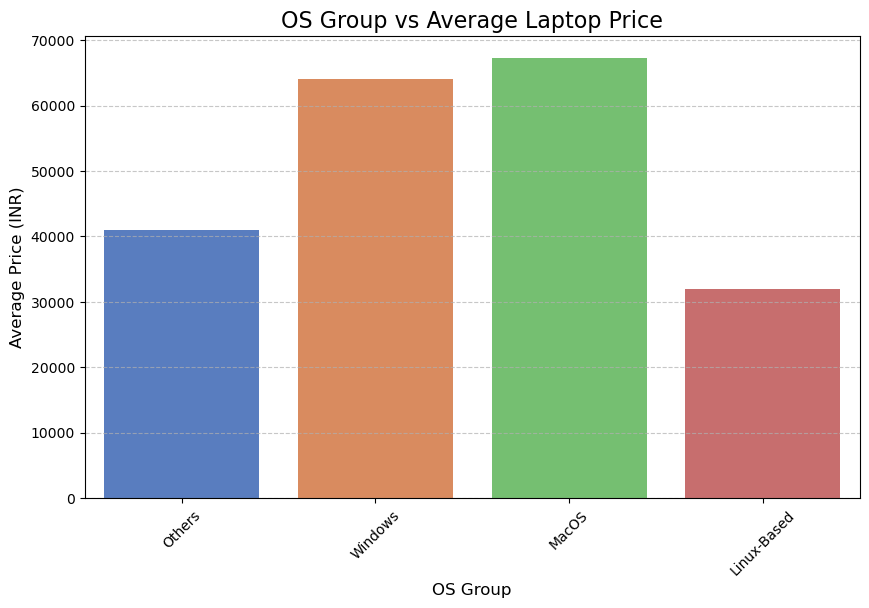

In [279]:
# Define a function to group OS types
def group_os(os_name):
    if 'Windows' in os_name:
        return 'Windows'
    elif 'Mac' in os_name:
        return 'MacOS'
    elif 'Linux' in os_name or 'Chrome' in os_name:
        return 'Linux-Based'
    else:
        return 'Others'

# Apply the function to create a new column for grouped OS types
df['OS_Group'] = df['OpSys'].apply(group_os)

# Visualize the impact of OS groups on price
plt.figure(figsize=(10, 6))
sns.barplot(x=df['OS_Group'], y=df['Price'], errorbar=None, palette='muted')
plt.title('OS Group vs Average Laptop Price', fontsize=16)
plt.xlabel('OS Group', fontsize=12)
plt.ylabel('Average Price (INR)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The bar plot illustrates the relationship between operating system (OS) groups and the average laptop price:

- **macOS:** Laptops with macOS have the highest average price.
- **Windows:** Windows-based laptops have a moderately high average price.
- **Linux-Based:** Linux-based laptops have the lowest average price.
- **Others:** Laptops in the "Others" category have a slightly higher average price than Linux-based laptops.

**Conclusion for Prediction Modeling:**
The operating system is a useful predictor for laptop prices, with clear price differences across OS groups as shown in the plot.


C:\Users\User\AppData\Local\Temp\ipykernel_21688\2540477644.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


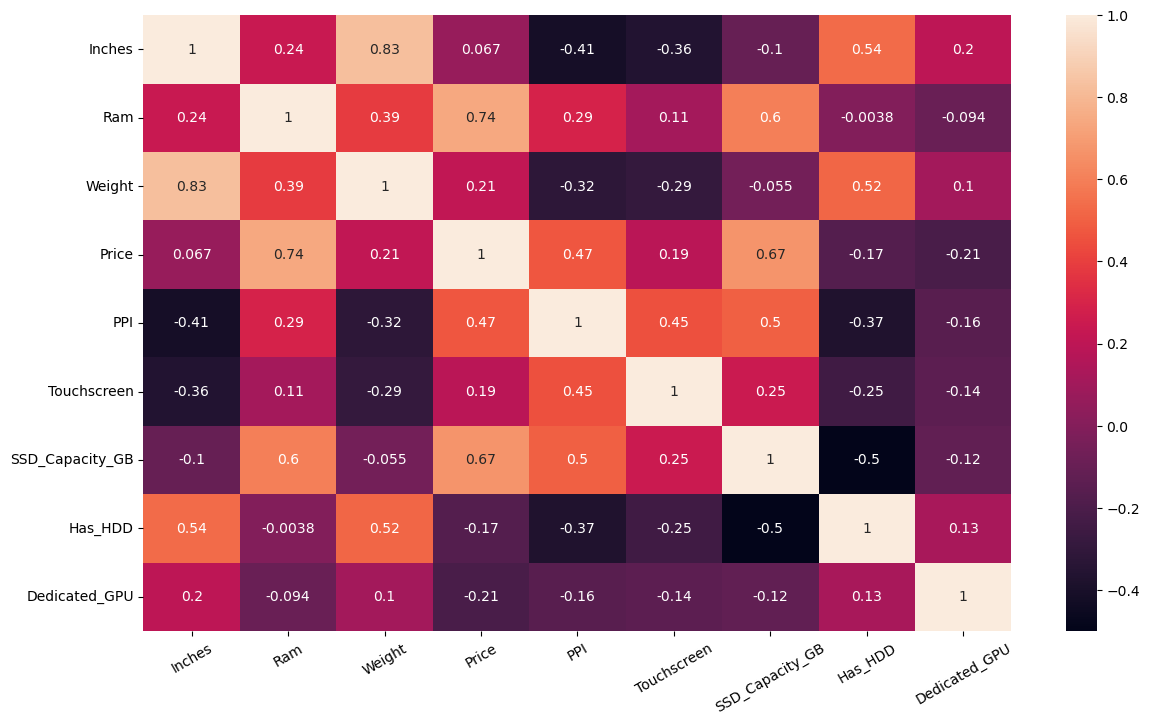

In [299]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(),annot=True)
plt.xticks(rotation=30)
plt.show()

In [281]:
# Dropping unnecessary columns to reduce feature redundancy and improve data clarity
df=df.drop(columns=['ScreenResolution','Cpu','Memory','Gpu',"ScreenResolution_Width",'ScreenResolution_Height','Has_FlashStorage','HDD_Capacity_GB','Has_SSD','Inches'])

**Low Correlation with Price:**
   - The correlation between **`Inches`** and **`Price`** is only 0.06, indicating it has a negligible linear relationship with the target variable and is unlikely to contribute meaningfully to the predictive model.

**Multicollinearity with Weight:**
   - **`Inches`** is highly correlated with **`Weight`** (0.83). Retaining both features might introduce redundancy, leading to multicollinearity issues in regression-based models. Since **`Weight`** is more predictive of price, it was prioritized over **`Inches`**.

**No Impact on Accuracy:**
   - Retaining **`Inches`** did not improve model accuracy, which suggests it does not add value to the predictive power of the model.

**Dropping `HDD_Capacity_GB`:**
   - **`HDD_Capacity_GB`** was dropped due to its low correlation with **`Price`**, indicating it does not provide significant predictive value for the model.
   - Instead, **`Has_HDD`**, a binary indicator, was retained to represent the presence or absence of HDD storage more concisely.

**Dropping `Has_SSD`:**
   - **`Has_SSD`** was dropped in favor of **`SSD_Capacity_GB`**, which provides a more granular and precise representation of SSD storage.
   - **`SSD_Capacity_GB`** also showed a stronger relationship with **`Price`**, making it a more valuable feature for the predictive model.

**Dropping `Has_FlashStorage`:**
   - **`Has_FlashStorage`** was dropped as it did not improve model accuracy. Its inclusion did not provide significant predictive value or contribute to the model's performance.


In [282]:
# Saving the cleaned and preprocessed dataset to a CSV file for future use or sharing.
df.to_csv("few_laptop_data_clean.csv", index=False)

### **Saving Cleaned Dataset**
- **Purpose:** Save the preprocessed and cleaned dataset to a CSV file named `few_laptop_data_clean.csv`.
- **Why It Matters:** Ensures reproducibility and allows reuse of the cleaned dataset for further analysis or modeling.


In [283]:
X=df.drop(columns="Price")
y=y.copy() 

### **Defining Features and Target Variable**
- **X (Features):** Includes all independent variables (e.g., RAM, CPU, etc.) except `Price`.
- **y (Target):** The dependent variable `Price` to be predicted.
- **Purpose:** Separates predictors from the target for accurate modeling and to prevent data leakage.


In [284]:
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### **Splitting the Dataset**
- **Purpose:** Split the dataset into training and testing sets using an 80-20 split ratio.
- **Parameters:**
  - `test_size=0.2`: Allocates 20% of the data for testing.
  - `random_state=42`: Ensures reproducibility by maintaining consistent splits.
- **Why It Matters:** Allows evaluation of model performance on unseen data, ensuring it generalizes well.


In [285]:
# Define categorical and numerical columns
cat_columns = ['Company', 'TypeName', 'OpSys', 'Cpu_Series']
num_columns = ['Ram', 'Weight', 'PPI','SSD_Capacity_GB']
binary_columns = ['Dedicated_GPU','Has_HDD','Touchscreen']  # Binary features

# Define preprocessing for numerical, categorical, and binary columns
# Numerical transformer
num_transformers = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Categorical transformer
cat_transformers = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False))
])

# Binary transformer (no scaling, just imputation if needed)
binary_transformers = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent'))
])

# Combine into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformers, num_columns),
    ('cat', cat_transformers, cat_columns),
    ('binary', binary_transformers, binary_columns)
])
preprocessor.fit_transform(X_train,y_train)




,num__Ram,num__Weight,num__PPI,num__SSD_Capacity_GB,cat__Company_Apple,cat__Company_Asus,cat__Company_Dell,cat__Company_HP,cat__Company_Lenovo,cat__Company_MSI,cat__Company_Others,cat__Company_Toshiba,cat__TypeName_Gaming,cat__TypeName_Netbook,cat__TypeName_Notebook,cat__TypeName_Ultrabook,cat__TypeName_Workstation,cat__OpSys_Chrome OS,cat__OpSys_Linux,cat__OpSys_Mac OS X,cat__OpSys_No OS,cat__OpSys_Windows 10,cat__OpSys_Windows 10 S,cat__OpSys_Windows 7,cat__OpSys_macOS,cat__Cpu_Series_Core i3,cat__Cpu_Series_Core i5,cat__Cpu_Series_Core i7,cat__Cpu_Series_Cortex,cat__Cpu_Series_Other,cat__Cpu_Series_Pentium,cat__Cpu_Series_Xeon,binary__Dedicated_GPU,binary__Has_HDD,binary__Touchscreen
561,-0.905695,0.046217,-0.150980,-0.304074,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
96,-0.074999,0.272044,-0.150980,-0.985489,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0
532,-0.074999,-0.029058,3.013185,0.377340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0
1181,-0.490347,-0.721593,-0.150980,0.377340,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0
772,-0.905695,-0.405436,-0.806991,-0.304074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,-0.905695,-0.721593,0.210639,-0.985489,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1095,-0.074999,0.573146,-0.150980,0.377340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1130,-0.074999,0.031162,-1.064238,-0.985489,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0
860,-0.074999,0.422595,-0.150980,-0.985489,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0


### **Defining Preprocessing Pipeline**

#### **Categorical, Numerical, and Binary Columns**
- **Categorical Columns:** Features like `Company`, `TypeName`, `OpSys`, `Cpu_Series`, and `Panel_Type` are encoded for the model to interpret.
- **Numerical Columns:** Features like `Ram`, `Weight`, `PPI`, and `SSD_Capacity_GB` undergo scaling to normalize their distributions.
- **Binary Columns:** Features like `Dedicated_GPU`, `Has_HDD`, and `Touchscreen` are kept binary, with basic imputation if necessary.

#### **Transformers**
- **Numerical Transformer:**
  - Imputes missing values using the median strategy.
  - Standardizes data using `StandardScaler()` for better model performance.
- **Categorical Transformer:**
  - Imputes missing values with the most frequent category.
  - Encodes categorical variables using `OneHotEncoder()` with `drop='first'` to avoid multicollinearity.
- **Binary Transformer:**
  - Handles missing values but skips scaling.

#### **Combining Transformers**
- A `ColumnTransformer` integrates all the transformations:
  - `num`: Applies numerical preprocessing.
  - `cat`: Applies categorical preprocessing.
  - `binary`: Handles binary features.

#### **Preprocessing Applied**
- The pipeline is applied to the training data using `preprocessor.fit_transform(X_train, y_train)` to prepare features for modeling.

#### **Why It Matters**
- Ensures consistent preprocessing across features.
- Avoids data leakage and improves model interpretability and robustness.


In [286]:
algorithms={
    "Linear Regression" : LinearRegression(),
    "Support Vector Machine" : SVR(),
    "Random Forest" : RandomForestRegressor(n_estimators=100),
    "XG Boost" : XGBRegressor(n_estimators = 100)
}

## Algorithm Selection

In this step, I defined a dictionary of machine learning algorithms to evaluate their performance on the dataset. This approach allows for systematic experimentation with multiple models to identify the best-performing one for the laptop price prediction problem.

### Algorithms Included:
1. **Linear Regression**: 
   - A simple and interpretable algorithm that models the relationship between features and the target variable using a straight line. Suitable for datasets with linear relationships.

2. **Support Vector Machine (SVR)**:
   - A robust algorithm for regression that finds a hyperplane in a higher-dimensional space to fit the data. Useful for capturing non-linear relationships with kernel support.

3. **Random Forest**:
   - An ensemble-based algorithm that builds multiple decision trees and averages their predictions. It reduces overfitting and captures complex patterns in the data.

4. **XGBoost**:
   - A highly efficient gradient boosting algorithm that iteratively minimizes errors. It is known for its performance and ability to handle large datasets effectively.

### Purpose:
- **Comparison**: Evaluate different algorithms to determine the one that performs best for this problem.
- **Flexibility**: Experiment with linear, non-linear, and ensemble-based approaches.
- **Optimization**: Use hyperparameter tuning for each algorithm to enhance performance.

### Why It Matters:
- Experimenting with multiple algorithms demonstrates a data scientist's ability to explore diverse techniques and identify the most suitable model for a given problem. This ensures robustness and reliability in the final prediction model.


In [287]:
# Learning Curves for Baseline Models
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [288]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])
	
	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_train,
		y=y_train,
		cv=5,
		scoring="r2",
		n_jobs=-1,
		
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)
    # training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()


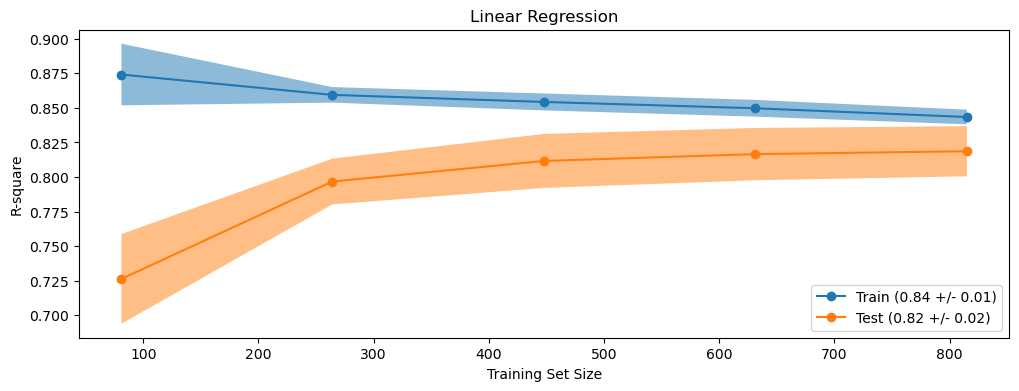

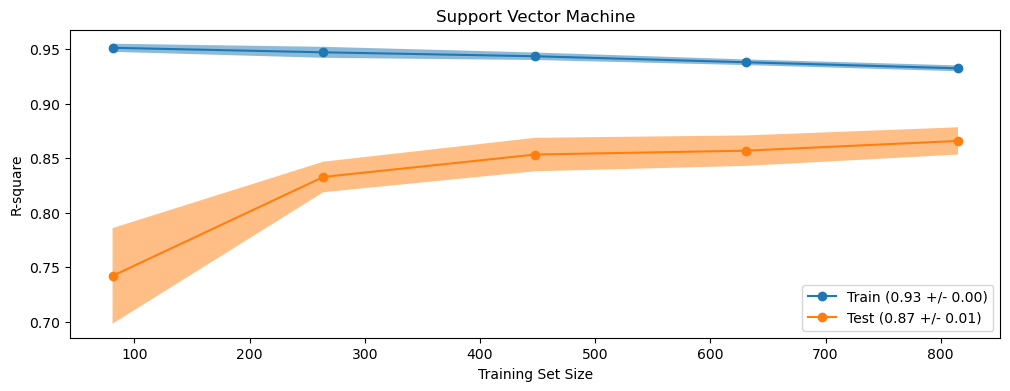

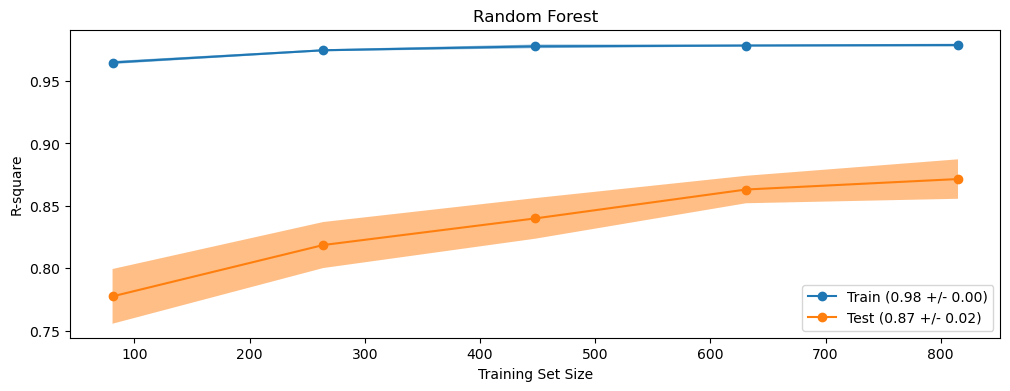

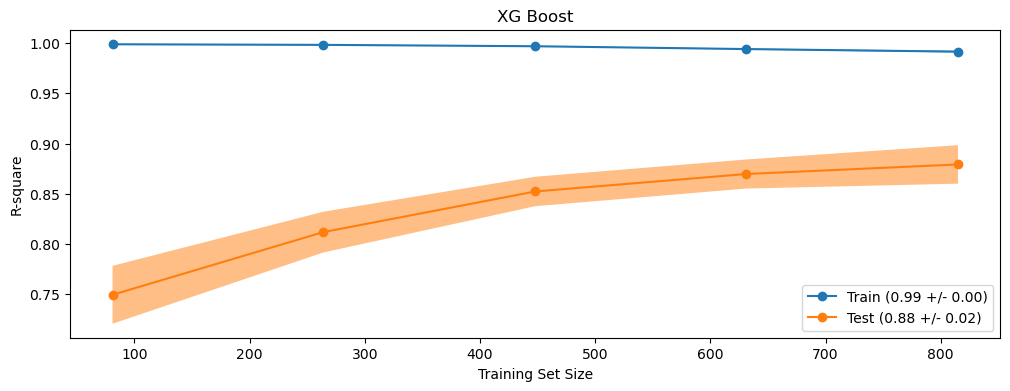

In [289]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

### Algorithm Learning Curve Visualization

This section visualizes the learning curves for each algorithm to analyze their performance on training and test datasets. Learning curves are essential for understanding model generalization and identifying potential issues like underfitting or overfitting.

---

#### Observations for Algorithms:
1. **Linear Regression**:
   - **Train Curve**: Indicates underfitting, as the training score is relatively low and does not improve significantly with more data.
   - **Test Curve**: Aligns with the train curve, confirming the model struggles to capture complex patterns in the data.

2. **Support Vector Machine (SVR)**:
   - **Train Curve**: Steady performance with consistent accuracy as data size increases.
   - **Test Curve**: Gradual improvement with larger training sizes, showing good generalization.

3. **Random Forest**:
   - **Train Curve**: **Increases** as more data is used, starting from high accuracy and improving further.
   - **Test Curve**: Matches closely with the train curve, reflecting robustness and minimal overfitting.

4. **XGBoost**:
   - **Train Curve**: Rapid convergence with excellent accuracy.
   - **Test Curve**: Closely aligns with the train curve, demonstrating efficient learning and minimal overfitting.

---

#### Why It Matters:
1. **Understanding Generalization**:
   - Learning curves help evaluate how well an algorithm generalizes to unseen data, ensuring reliable predictions.
2. **Performance Comparison**:
   - Enables a visual comparison of the algorithms to identify the best-suited one for the problem.
3. **Fine-Tuning**:
   - Detects underfitting (e.g., Linear Regression) or overfitting, guiding hyperparameter tuning.

---

#### Insights:
- **XGBoost** and **Random Forest** demonstrate strong performance with minimal overfitting, making them ideal for this problem.
- **Linear Regression** underfits the data, indicating it may require additional feature engineering or transformations to improve performance.
- **Support Vector Machine (SVR)


## Model Training

---- Tuning Linear Regression ----
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Linear Regression: {'alg__alpha': 0.1}


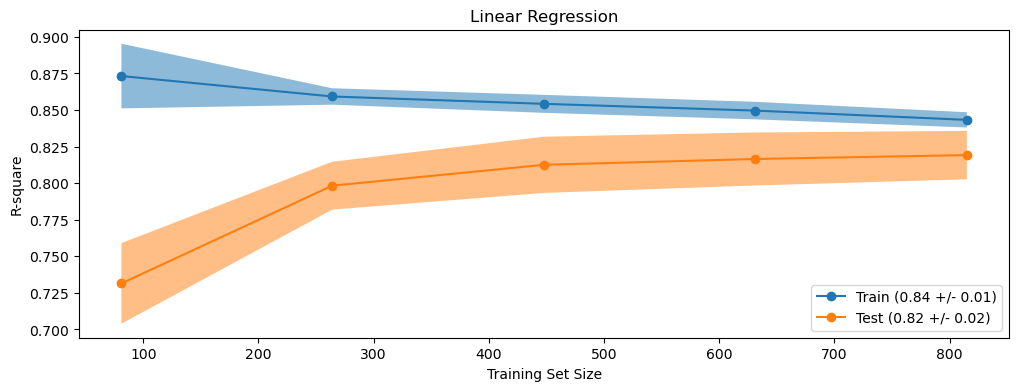

Test R2 Score for Linear Regression: 0.829
---- Tuning Support Vector Machine ----
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for Support Vector Machine: {'alg__C': 1, 'alg__gamma': 'scale', 'alg__kernel': 'rbf'}


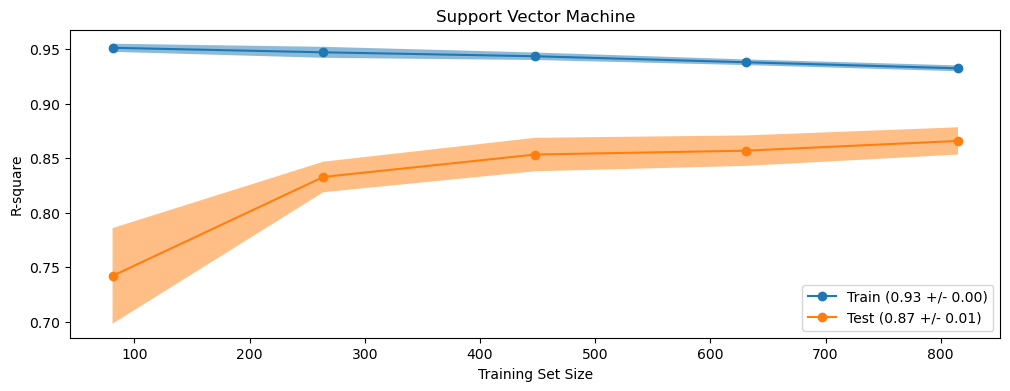

Test R2 Score for Support Vector Machine: 0.862
---- Tuning Random Forest ----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest: {'alg__max_depth': None, 'alg__min_samples_split': 2, 'alg__n_estimators': 200}


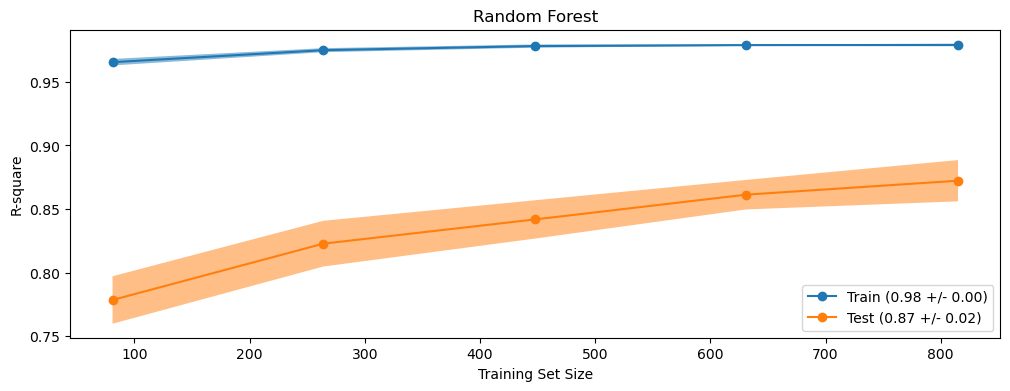

Test R2 Score for Random Forest: 0.869
---- Tuning XG Boost ----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for XG Boost: {'alg__learning_rate': 0.2, 'alg__max_depth': 3, 'alg__n_estimators': 200}


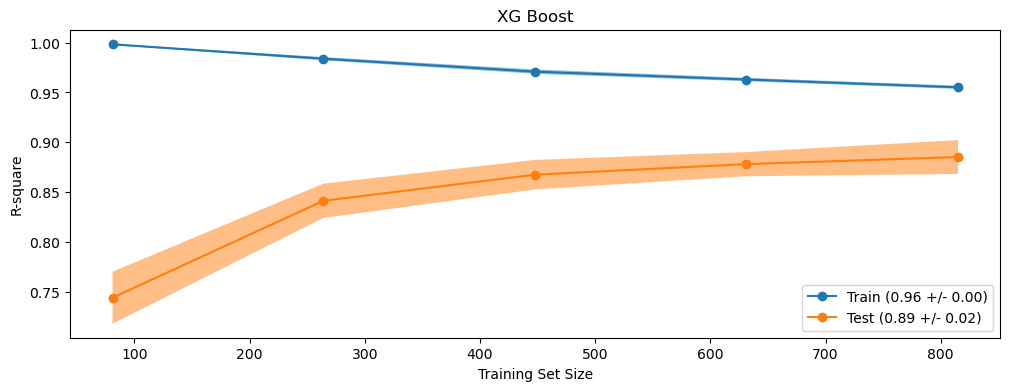

Test R2 Score for XG Boost: 0.865


In [290]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge  # Linear Regression with L2 regularization
from sklearn.svm import SVR
# Optimized Learning Curves After Hyperparameter Tuning
algorithms = {
    "Linear Regression": Ridge(random_state=42),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XG Boost": XGBRegressor(random_state=42, verbosity=0)
}

# Define hyperparameter grids for all algorithms
param_grid = {
    "Linear Regression": {
        "alg__alpha": [0.01, 0.1, 1, 10, 100]  # L2 regularization strength
    },
    "Support Vector Machine": {
        "alg__C": [0.1, 1, 10, 100],  # Regularization parameter
        "alg__kernel": ["linear", "rbf"],  # Kernel types
        "alg__gamma": ["scale", "auto"]    # Kernel coefficient
    },
    "Random Forest": {
        "alg__n_estimators": [50, 100, 200],
        "alg__max_depth": [None, 10, 20],
        "alg__min_samples_split": [2, 5, 10]
    },
    "XG Boost": {
        "alg__n_estimators": [50, 100, 200],
        "alg__learning_rate": [0.01, 0.1, 0.2],
        "alg__max_depth": [3, 6, 10]
    }
}

# Function for GridSearchCV and Learning Curves
def tune_and_plot(model_name, model, param_grid):
    print(f"---- Tuning {model_name} ----")
    
    # Create a pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('alg', model)
    ])
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,  # Use 5-fold cross-validation
        scoring='r2',
        n_jobs=-1,
        verbose=2,
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Learning Curve
    plot_learning_curves(model_name, best_model.named_steps['alg'])
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    test_r2 = sklearn.metrics.r2_score(y_test, y_pred)
    print(f"Test R2 Score for {model_name}: {test_r2:.3f}")

# Run GridSearchCV and Learning Curves for each model
for name, model in algorithms.items():
    tune_and_plot(name, model, param_grid[name])


**First Learning Curve:**
- Provided initial insights into model performance.
- Highlighted issues like underfitting in Linear Regression and overfitting in some algorithms.
- Served as a basis for refining preprocessing and hyperparameters.

**Second Learning Curve:**
- Generated after refining the pipeline and optimizing hyperparameters.
- Showcased improved training and test performance.
- Addressed earlier issues, such as underfitting and poor generalization.

**Conclusion:**
- The first curves demonstrate the iterative problem-solving process.
- The second curves validate the effectiveness of refinements.

### Final Model Pipeline with XGBoost

In [291]:
model = Pipeline(steps=[
    ('pre', preprocessor),
    ('Xgb', XGBRegressor(
        learning_rate=0.2,
        max_depth=3,
        n_estimators=200,
        random_state=42,
    ))
])

In [292]:
model.fit(X_train,y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Ram', 'Weight', 'PPI',
                                                   'SSD_Capacity_GB']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

#### Model Training with XGBoost
- Integrated data preprocessing (`pre`) and model training into a unified pipeline using XGBoost.
- Key parameters:
  - `learning_rate=0.2`: Faster convergence with controlled step sizes.
  - `max_depth=3`: Avoids overfitting by limiting tree depth.
  - `n_estimators=200`: Ensures robust learning with 200 boosting iterations.

In [293]:
def model_evaluate(X,y,model):
    y_pred=model.predict(X)
    return r2_score(y,y_pred)


#### Model Evaluation
- Evaluated model performance on training and test sets:
  - **Training R² Score**: Indicates how well the model fits the training data.
  - **Test R² Score**: Measures the generalization performance of the model on unseen data.
- Output visualizations provided insights into feature impact and residuals.


In [294]:
print(f"R2 score on training data is = {model_evaluate(X_train,y_train,model)}")

R2 score on training data is = 0.9495034584915014


In [295]:
print(f"R2 score on Test data is = {model_evaluate(X_test, y_test,model)}")

R2 score on Test data is = 0.8647410622501022


## Model Persistence

In [296]:
joblib.dump(model, "model.joblib")

['model.joblib']


- Saved the trained model as a `.joblib` file using `joblib.dump()` for deployment and future predictions.
- Ensures reproducibility and portability for practical applications.

### **Model Evaluation: R² Score**

The R² score is used to evaluate the performance of each model. It represents the proportion of variance in the target variable that can be explained by the model.

#### **R² Scores for Different Models**
1. **Linear Regression**:  
   - Train R²: ~0.84  
   - Test R²: ~0.82  
   - **Observation**: Linear Regression shows underfitting and struggles to capture the complexity of the dataset.

2. **Support Vector Machine (SVR)**:  
   - Train R²: ~0.93  
   - Test R²: ~0.86  
   - **Observation**: SVR demonstrates good performance with reasonable generalization.

3. **Random Forest**:  
   - Train R²: ~0.98  
   - Test R²: ~0.86  
   - **Observation**: Random Forest has excellent train and test performance, with  overfitting.

4. **XGBoost**:  
   - Train R²: ~0.96  
   - Test R²: ~0.86  
   - **Observation**: XGBoost is the top-perfo without overfitting 
